### Use Python LightGBM and BayesSearchCV to build model and deploy with KNIME Python nodes


<img src="../KNIME_loves_lightgbm.png" width="600">


##### KNIME workflow
https://hub.knime.com/-/spaces/-/latest/~GABT_OgeoWxWJW9P/


##### GitHub: A small collection of Jupyter Notebooks to solve CLASSIFICATION tasks

https://github.com/ml-score/knime_meets_python/tree/main/machine_learning/binary

##### MEDIUM Blog: Hyperparameter optimization for LightGBM — wrapped in KNIME nodes

https://medium.com/p/ddb7ae1d7e2

##### Medium Blog: KNIME — Machine Learning and Artificial Intelligence— A Collection

https://medium.com/p/12e0f7d83b50

##### Medium Blog: About Machine-Learning — How it Fails and Succeeds

https://medium.com/p/9f3ab7cb9b00


###### additional links and texts

https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#for-better-accuracy

https://stackoverflow.com/questions/67080149/xgboost-error-when-categorical-type-is-supplied-dmatrix-parameter-enable-cat


https://towardsdatascience.com/how-to-beat-the-heck-out-of-xgboost-with-lightgbm-comprehensive-tutorial-5eba52195997

https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5


https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f

some parameters have been discussed with ChatGPT ....

In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import json
import pickle

In [2]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc, average_precision_score, precision_recall_curve
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import matplotlib.pyplot as plt

In [3]:
# http://strftime.org'
import time
var_timestamp_day = "{}".format(time.strftime("%Y%m%d"))
# flow_variables['var_timestamp_day'] = var_timestamp_day
print("var_timestamp_day: ", var_timestamp_day)

var_timestamp_time = "{}h".format(time.strftime("%H%M"))
# flow_variables['var_timestamp_time'] = var_timestamp_time
print("var_timestamp_time: ", var_timestamp_time)

# _edit: if you want to have another model name
var_model_name = "LightGBM_BayesSearchCV_Classification"
# flow_variables['var_model_name'] = var_model_name

var_model_name_full = var_model_name + "_" + var_timestamp_day  + "_" + var_timestamp_time + "_jupyter"
# flow_variables['var_model_name_full'] = var_model_name_full
print("var_model_name_full: ", var_model_name_full)

# if you dp not want to store the files in the working directory
var_path_data = "../result/"
var_path_model = "../model/"

var_timestamp_day:  20240322
var_timestamp_time:  1403h
var_model_name_full:  LightGBM_BayesSearchCV_Classification_20240322_1403h_jupyter


In [4]:
data      = pq.read_table("../train.parquet").to_pandas()
data_test = pq.read_table("../test.parquet").to_pandas()

In [5]:
data = data.reset_index(drop=True)

In [6]:
data_test = data_test.reset_index(drop=True)

In [7]:
excluded_features = ['row_id']
label = ['Target']
# features = [feat for feat in data.columns if feat not in excluded_features and not feat==label]
features = [feat for feat in data.columns if feat not in excluded_features and feat not in label]

num_cols = data[features].select_dtypes(include='number').columns.tolist()
cat_cols = data[features].select_dtypes(exclude='number').columns.tolist()

rest_cols = [feat for feat in data.columns if feat not in cat_cols]

print(f'''{"data shape:":20} {data.shape}
{"data[features] shape:":20} {data[features].shape}
categorical columns: {cat_cols}
numerical columns: {num_cols}
feature columns: {features}
rest columns: {rest_cols}''')

# THX David Gutmann 

data shape:          (34189, 16)
data[features] shape: (34189, 14)
categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numerical columns: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
feature columns: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
rest columns: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'Target', 'row_id']


In [8]:
print(data.dtypes)

age                int32
workclass         object
fnlwgt             int32
education         object
education-num      int32
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int32
capital-loss       int32
hours-per-week     int32
native-country    object
Target            object
row_id            object
dtype: object


In [9]:
data[cat_cols] = data[cat_cols].astype('category')

In [10]:
data[label] = data[label].astype('int32')

In [11]:
print(data.dtypes)

age                  int32
workclass         category
fnlwgt               int32
education         category
education-num        int32
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain         int32
capital-loss         int32
hours-per-week       int32
native-country    category
Target               int32
row_id              object
dtype: object


In [12]:
# split data into X and y
X = data[features]
y = data[label]

In [13]:
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
3,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States
4,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica


In [14]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [15]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [16]:
X_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
30134,34,Private,159442,HS-grad,9,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,37,Ireland
17779,23,Private,32950,Some-college,10,Never-married,Transport-moving,Not-in-family,White,Male,4101,0,40,United-States
16031,26,Private,36201,Bachelors,13,Never-married,Sales,Not-in-family,White,Male,0,0,50,United-States
24306,49,Private,47403,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States
28051,41,Private,145441,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States


In [17]:
import sklearn
print(sklearn.metrics.get_scorer_names())

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'neg_root_mean_squared_log_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc',

In [18]:
# define the search space for hyperparameters
# https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html

# number of iterations
var_n_iter = 200

space  = {
    'learning_rate': Real(0.01, 0.5, 'log-uniform'), # step size shrinkage used to prevent overfitting. Lower values = more accuracy but slower training
    'num_leaves': Integer(25, 500), # the maximum number of leaves in any tree
    'max_depth': Integer(6, 15), # the maximum depth of any tree
    'min_child_samples': Integer(1, 20), # minimum number of samples required in a child node to be split
    'feature_fraction': Real(0.1, 0.9), # fraction of features used for each boosting iteration
    'bagging_fraction': Real(0.1, 0.9), # fraction of the training data to be used for each iteration
    'bagging_freq': Integer(1, 10), # number of iterations to perform bagging (sample of data to grow trees)
    # 'lambda_l1': Integer(0, 100), # L1 regularization term on weights
    # 'lambda_l2': Integer(0, 100), # L2 regularization term on weights
    'reg_alpha': Real(0, 2), # L1 regularization term on weights
    'reg_lambda': Real(0, 2), # L2 regularization term on weights
    'class_weight': Categorical(['balanced', None]), # weighting of positive classes in binary classification problems
    'boosting_type': Categorical(['gbdt', 'dart']), # type of boosting algorithm to use
    'objective': Categorical(['binary']), # objective function to use for training
    'metric': Categorical(['aucpr']), # evaluation metric to use for early stopping and model selection
    'subsample': Real(0.1, 1.0, 'uniform'), # fraction of data samples used for each iteration
    'colsample_bytree': Real(0.1, 1.0, 'uniform'), # fraction of features used for each iteration
    # 'min_gain_to_split': Integer(0, 15), # minimum gain required to make a split
    'min_split_gain': Real(0, 1.0, 'uniform'), # minimum gain required to make a split
    'n_estimators': Integer(250, 1000), # number of trees in the model
    # 'early_stopping_rounds': Integer(25, 100), # number of iterations with no improvement after which training will stop
    'importance_type': Categorical(['split', 'gain']), # type of feature importance to use for feature selection
    'scale_pos_weight': Real(0.1, 10.0, 'uniform') # control the balance of positive and negative weights
}


In [ ]:
# define the LightGBM classifier
# clf = lgb.LGBMClassifier(categorical_feature=cat_cols)
clf = lgb.LGBMClassifier()

# define the optimizer
opt = BayesSearchCV(
    clf,
    space,
    n_iter=var_n_iter,
    # n_points=1 - Number of parameter settings to sample in parallel. If this does not align with n_iter, 
    # the last iteration will sample less points.
    n_points=3, 
    cv=5,
    n_jobs=-1,
    return_train_score=True,
    refit=True,
    # https://scikit-optimize.github.io/stable/modules/generated/skopt.Optimizer.html#skopt.Optimizer
    optimizer_kwargs={'base_estimator': 'GP'},
    scoring='average_precision',
    random_state=42 # set the seed here
)

# perform the hyperparameter search
opt.fit(X_train, y_train)

In [20]:
# extract the best model
best_model = opt.best_estimator_

# show the best parameters
print(best_model.get_params)

# evaluate the best model on the test data
y_pred = best_model.predict_proba(X_test)[:,1]

# evaluate the initial values based on the (internal Test data)
auc_pred = roc_auc_score(y_test, y_pred, average='weighted')
print(f'Test AUC: {auc_pred:.4f}')

aucpr = average_precision_score(y_test, y_pred, average='weighted') #, pos_label='1'
print(f'Test AUCPR: {aucpr:.4f}')


<bound method LGBMModel.get_params of LGBMClassifier(bagging_fraction=0.9, bagging_freq=2, boosting_type='dart',
               class_weight='balanced', feature_fraction=0.5808289943636789,
               importance_type='gain', learning_rate=0.0955483952941569,
               max_depth=6, metric='aucpr', min_child_samples=1,
               min_split_gain=0.4671001929862508, n_estimators=389,
               num_leaves=321, objective='binary', scale_pos_weight=0.1,
               subsample=0.8624151559219462)>
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5808289943636789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5808289943636789
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.8624151559219462 will be ignored. Current value: bagging_fraction=0.9
Test AUC: 0.9314
Test AUCPR: 0.8371
[LightGBM] [Warning] No further splits with positive ga

In [21]:
import pickle
# set the path for the pickel file
path_model = var_path_model + var_model_name_full + "_model_stored.pkl"
# Save object as pickle file
pickle.dump(best_model, open(path_model, 'wb'), pickle.HIGHEST_PROTOCOL)

In [22]:
# extract the feature importance
# https://www.kaggle.com/code/ashishpatel26/feature-importance-of-lightgbm

feature_imp = pd.DataFrame(sorted(zip(best_model.feature_importances_,X_test.columns)), columns=['Value','Feature'])
feature_imp = feature_imp.sort_values(by='Value', ascending=False, na_position='last')

feature_imp = feature_imp.reset_index(drop=True)
feature_imp['Feature_Rank'] = feature_imp.index

In [23]:
feature_imp.head()

,Value,Feature,Feature_Rank
0,9489.671498,capital-gain,0
1,5274.316597,relationship,1
2,4082.038003,education-num,2
3,4022.753763,age,3
4,3987.371213,capital-loss,4


In [24]:
feature_imp.to_parquet(var_path_model + var_model_name_full + "_feature_importance.parquet", compression='gzip')

In [25]:
type(y_pred)

numpy.ndarray

In [26]:
# store the variales list as dictionary in a JSON file to read back later

v_variable_list = {
    "var_model_name": var_model_name,
    "var_model_name_full": var_model_name_full,
    "num_cols": num_cols,
    "cat_cols": cat_cols,
    "rest_cols": rest_cols,
    "label": label,
    "features": features,
    "excluded_features": excluded_features,
    "Test_AUC": f'{auc_pred:.5f}',
    "Test_AUCPR": f'{aucpr:.5f}'
}

In [27]:
print(v_variable_list)

{'var_model_name': 'LightGBM_BayesSearchCV_Classification', 'var_model_name_full': 'LightGBM_BayesSearchCV_Classification_20240322_1403h_jupyter', 'num_cols': ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'], 'cat_cols': ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'], 'rest_cols': ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'Target', 'row_id'], 'label': ['Target'], 'features': ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'], 'excluded_features': ['row_id'], 'Test_AUC': '0.93139', 'Test_AUCPR': '0.83714'}


In [28]:
type(v_variable_list)

dict

In [29]:
# Write the dictionary to a JSON file
with open(var_path_model + var_model_name_full + "_variable_list.json", "w") as f:
    json.dump(v_variable_list, f)

In [30]:
# show the best parameters
best_parameters = best_model.get_params
print(best_parameters)

<bound method LGBMModel.get_params of LGBMClassifier(bagging_fraction=0.9, bagging_freq=2, boosting_type='dart',
               class_weight='balanced', feature_fraction=0.5808289943636789,
               importance_type='gain', learning_rate=0.0955483952941569,
               max_depth=6, metric='aucpr', min_child_samples=1,
               min_split_gain=0.4671001929862508, n_estimators=389,
               num_leaves=321, objective='binary', scale_pos_weight=0.1,
               subsample=0.8624151559219462)>


In [31]:
with open(var_path_model + var_model_name_full + "_model_parameters.txt", "w") as file:
    print(best_parameters, file=file)

In [32]:
df_best_parameters = pd.read_csv(var_path_model + var_model_name_full + "_model_parameters.txt", sep = "@",header = None, names=["lgbm_parameters"])

In [33]:
df_best_parameters.head()

,lgbm_parameters
0,<bound method LGBMModel.get_params of LGBMClas...
1,"class_weight='balanced', featur..."
2,"importance_type='gain', learnin..."
3,"max_depth=6, metric='aucpr', mi..."
4,min_split_gain=0.46710019298625...


## Apply the LightGBM model with all the settings

In [34]:
import pickle
# set the path for the pickel file
path_apply_model = var_path_model + var_model_name_full + "_model_stored.pkl"

clf_apply = pickle.load(open(path_apply_model, 'rb'))

In [35]:
import json

# Read the JSON file back into a Python dictionary
with open(var_path_model + var_model_name_full + "_variable_list.json", "r") as f:
    loaded_dict = json.load(f)

# fill the list of categorical columns
new_cat_cols = loaded_dict['cat_cols']
new_features = loaded_dict['features']

In [36]:
print(new_cat_cols)

['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [37]:
df_test_apply = data_test[new_features].copy()
df_test_apply[new_cat_cols] = df_test_apply[new_cat_cols].astype('category')

In [38]:
# Get the predicted probabilities for each class
probabilities = clf_apply.predict_proba(df_test_apply)
prediction = clf_apply.predict(df_test_apply)

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5808289943636789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5808289943636789
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.8624151559219462 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5808289943636789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5808289943636789
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.8624151559219462 will be ignored. Current value: bagging_fraction=0.9


In [39]:
probabilities_df = pd.DataFrame(probabilities, columns = ['P0','P1'])
prediction_df = pd.DataFrame(prediction, columns = ['Target_pred'])

In [40]:
prediction_df.head()

,Target_pred
0,0
1,0
2,0
3,0
4,0


In [41]:
# Join the original target column with the predicted probabilities
result = pd.concat([data_test, probabilities_df, prediction_df], axis=1)

In [42]:
result.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Target,row_id,P0,P1,Target_pred
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,Row0,0.822086,0.177914,0
1,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,Row1,0.706403,0.293597,0
2,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,1,Row2,0.714915,0.285085,0
3,32,Private,205019,Assoc-acdm,12,Never-married,Sales,Not-in-family,Black,Male,0,0,50,United-States,0,Row3,0.954198,0.045802,0
4,25,Self-emp-not-inc,176756,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,35,United-States,0,Row4,0.998629,0.001371,0


In [43]:
result.to_parquet(var_path_data + var_model_name_full + "_scored_test_data.parquet", compression='gzip')

In [44]:
# evaluate the best model on the test data
auc_pred = roc_auc_score(result['Target'], result['P1'], average='weighted')
print(f'Test AUC: {auc_pred:.4f}')

Test AUC: 0.9301


In [45]:
# from sklearn.metrics import average_precision_score
aucpr = average_precision_score(result['Target'], result['P1'], average='weighted', pos_label='1')
print(f'Test AUCPR: {aucpr:.4f}')

Test AUCPR: 0.8324


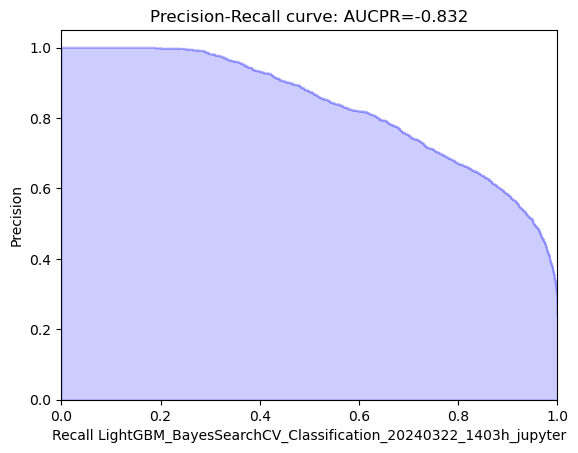

In [48]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_true = result["Target"].astype(int).values
y_score = result["P1"].values

precision, recall, thresholds = precision_recall_curve(y_true, y_score)
auc_pr = np.trapz(precision, recall)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall ' + var_model_name_full)
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AUCPR={0:0.3f}'.format(auc_pr))
plt.savefig(var_path_model + var_model_name_full + "_auc_plot.png")
plt.show()

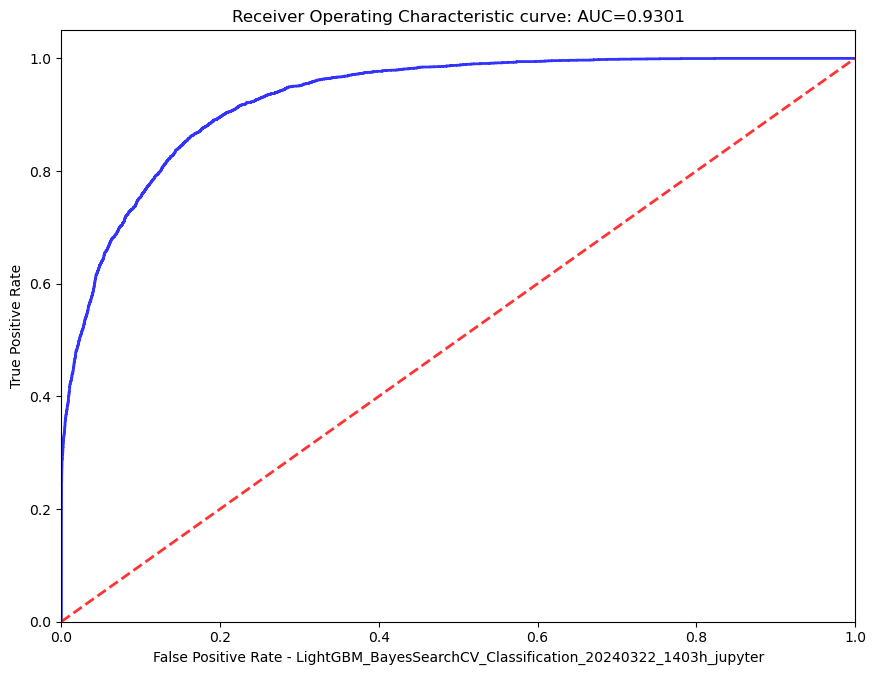

In [49]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_true = result["Target"].astype(int).values
y_score = result["P1"].values

fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc_roc = auc(fpr, tpr)

plt.tight_layout()
plt.gcf().set_size_inches(10.24, 7.68)
plt.plot(fpr, tpr, color='b', lw=2, alpha=0.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
plt.xlabel('False Positive Rate - ' + var_model_name_full)
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Receiver Operating Characteristic curve: AUC={0:0.4f}'.format(auc_roc))
plt.savefig(var_path_model + var_model_name_full + "_auc_plot.png")
plt.show()